# An Analysis of a 1D Scalar and Vector Advection Equation 

## Import Packages 

In [1]:
using LinearAlgebra
using DifferentialEquations
using SparseArrays
using FFTW 
using BenchmarkTools 
using Plots 

## Section 1: Introduction 

Here we study the scalar advection equation. 

<b>Linear Scalar Problem to Solve</b> Let $x \in \Omega=(0,1)$ denote the spatial domain. Let $t \in [0,T]$ denote the time interval. Let $c>0$ denote the velocity of wave propagation (the direction of the wave propagation will be taken care of fuirther). (Let $\gamma$ denote the friction coefficient.) Let $f(x,t)$ denote the (periodic or otherwise) forcing. The partial differential equation for the unknown $u(x,t)$ we intend to solve can be written as 

$$
\frac{\partial \, u}{\partial t} = - c \frac{\partial \, u}{\partial x} + f(x,t) 
$$ 

Non-linear terms will be added later. We supply periodic boundary condition for $u(x,t)$, i.e., we impose that 

$$
u(0,t) = u(1,t) \, . 
$$

We impose non-zero initial conditions for $u(x,t)$ and zero initial conditions for $\dot{u}(x,t)$, i.e., we impose that

$$
u(x,0) = u_0(x) \, . $$

<b>Finite Difference Spatial Discretization</b> We use a finite difference method on a uniform mesh for the discretization of the spatial variable. We assume an uniform mesh with $N$ elements, $N+1$ nodes ($N-1$ internal nodes plus the left-most and right-most boundary node) and mesh spacing $h = 1/N$.
1. use backward (forward) difference scheme for wave traveling from left to right (right to left).

<b>Time Stepping</b> To perform time-stepping, we employ DifferentialEqiuations.jl. 

The <b>motivation</b> for considering this problem is the fact that the shallow water equations can be viewed as a coupled system of advection equations.

In case that $f(x,t) = 0$ (no external forcing), an <b>analytical reference solution</b> is given by $u(x,t) = g(x+c*t)$, where g is an arbitrary function of $\xi = x - c*t$ (method of charateristics, verify by applying chain rule for derivatives). The graph of the function $g(\xi)$ is advected from left to right as time passes (flip signs to obtain propagation in other direction). 

In case that $f(x,t)$ is periodic, a reference solution (showing resonance as before), is given in e.g. [egger-2003](https://journals.ametsoc.org/view/journals/mwre/131/5/1520-0493_2003_131_0984_aewofn_2.0.co_2.xml?tab_body=pdf). 

## Section 2: Analytical Reference Solution 

To do:   
1. plot the wave travelling in opposite direction;
1. plot the wave with anti-periodic boundary conditions; 

In [34]:
function gaussPulse(xi)
    exp(-(xi-.2)^2/0.01)
end 

gaussPulse (generic function with 1 method)

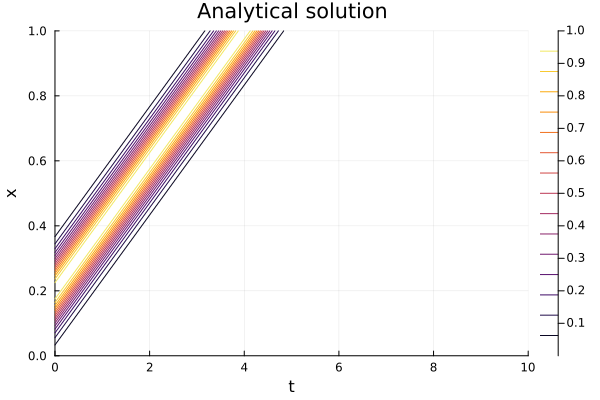

In [42]:
# pls observe the sign + in the analytical solution 
# pls observe the factor 2 to obtain a periodic solution 
function genAnalyticalSolution1(x,t,c)
    return sin(2*pi*x - 2*pi*c*t)
end 

function genAnalyticalSolution2(x,t,c)
    return gaussPulse(x-c*t)
end 

# set number of elements in space, the number of time samples and number of modes 
nelements = 100
Nt = 1000

#..construct the 1D spatial x-mesh and the spatial modes 
nnodes = nelements+1; h = 1/nelements; h2=h*h; 
x = Vector(0:h:1); 

#..construct temporal t-mesh  
Tend = 10; dt = Tend/Nt; 
t = Vector(0:dt:Tend);

#..set wave velocity and damping coefficients 
c = .2;
gamma = 0.5 # 0.5 

#..initialize and construct analytical solution 
uanal = [genAnalyticalSolution2(xi,tj,c) for xi in x, tj in t]

p1 = contour(t,x,uanal,xlabel="t",ylabel="x",title="Analytical solution")

plot(p1)

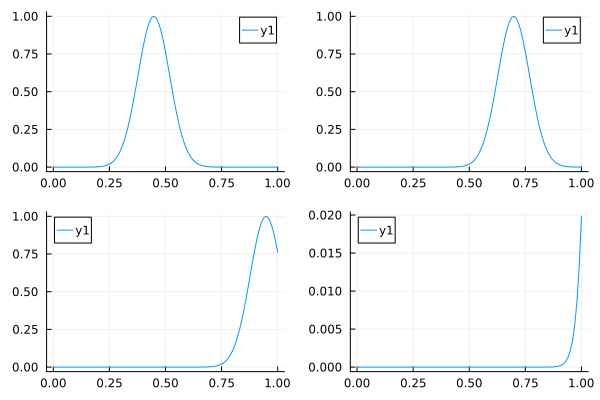

In [36]:
# plot time traces 
p1 = plot(x,uanal[:,Int64(Nt/8)])
p2 = plot(x,uanal[:,Int64(2*Nt/8)])
p3 = plot(x,uanal[:,Int64(3*Nt/8)])
p4 = plot(x,uanal[:,Int64(4*Nt/8)])
p5 = plot(x,uanal[:,Int64(5*Nt/8)])
p6 = plot(x,uanal[:,Int64(6*Nt/8)])
p7 = plot(x,uanal[:,Int64(7*Nt/8)])
p8 = plot(x,uanal[:,Int64(8*Nt/8)])
plot(p1,p2,p3,p4,layout=(2,2))
#plot(p5,p6,p7,p8,layout=(2,2))

## Section 3: Spatial Discretization: Construct the One-Dimensional Advection Matrix

1. using periodic boundary conditions, the linear algebra on a mesh with N+1 nodes leads to a linear system of size N-by-N. We omit the last node in the mesh. 
1. need to add upwind scheme? 
1. Implement backward difference scheme. 

In [103]:
# struct to hold entire mesh
struct Mesh
  #..number of nodes of the mesh..   
  nnodes::Int64
  #..number of elements of the mesh..
  nelements::Int64 
  #..vector of x-coordinates of nodes of the mesh..
  nodes::Vector{Float64}
  #..vector of x-coordinates of nodes of the mesh..
  midpoints::Vector{Float64}    
end 

# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = nelements+1
    nodes = Vector{Float64}(0:h:1) 
    midpoints = nodes[1:end-1] + (nodes[2:end] - nodes[1:end-1])/2
    mesh = Mesh(nnodes,nelements,nodes,midpoints)     
    return mesh;
end 

# generate N-by-N advection matrix by backward difference scheme with mesh width h
# leading to lower (L) bi-diagonal matrix 
function genAdvMatL(mesh::Mesh)

    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes    = nelements+1
    
    #..set mesh width and square of mesh width 
    h = 1/nelements

    #..construct the advection matrix\ 
    e = ones(nelements) 
    A = Bidiagonal(e, -e[2:end], :L)
    A = (1/h)*A     
   
    return A;     
end

# generate load vector of size N 
function genVector(mesh, sourceFct::F) where F 

    #..recover mesh nodes  
    nodes = mesh.nodes
    
    #..set vector values using broadcasting (dot syntax)  
    f = sourceFct.(nodes[1:end-1])
   
    return f; 
end

function genBoundariesL!(mesh,A,f)
    
    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes = mesh.nnodes 
    
    #..set mesh width and square of mesh width 
    h = 1/nelements
    
    A = sparse(A)
    A[1,end] = -1/h   

    return A,f   
end

function genBoundariesU!(mesh,A,f)
    
    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes = mesh.nnodes 
    
    #..set mesh width and square of mesh width 
    h = 1/nelements
    
    A = sparse(A)
    A[end,1] = 1/h   

    return A,f   
end

genBoundariesU! (generic function with 1 method)

Test above on small mesh. 

In [104]:
nelements = 4
mesh = genMesh(nelements)
myfct(x) = 0 
A = genAdvMatL(mesh); f = genVector(mesh, myfct) 
A,f = genBoundariesL!(mesh,A,f);
display(A)
#display(f)

4×4 SparseMatrixCSC{Float64, Int64} with 8 stored entries:
  4.0    ⋅     ⋅   -4.0
 -4.0   4.0    ⋅     ⋅ 
   ⋅   -4.0   4.0    ⋅ 
   ⋅     ⋅   -4.0   4.0

## Section 4: Time Integration of the (Non-)Linear Problem

To do: 
1. study the effect of the spatial mesh resolution 
1. study the effect of the non-linearity  

In [60]:
nelements = 1000
mesh = genMesh(nelements)
myfct(x) = 0 
A = genAdvMatL(mesh); f = genVector(mesh, myfct) 
A,f = genBoundariesL!(mesh,A,f);

In [63]:
function advection_system!(du,u,p,t)
    du .= -c*A*u
end
 
u0 = [genAnalyticalSolution2(xi,0,c) for xi in mesh.nodes[1:end-1]]

tspan = (0.0,10)

prob = ODEProblem(advection_system!,u0,tspan)
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8, save_everystep = true);

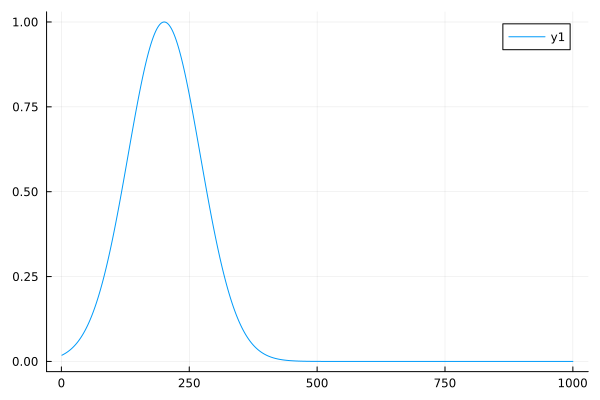

In [48]:
plot(u0)

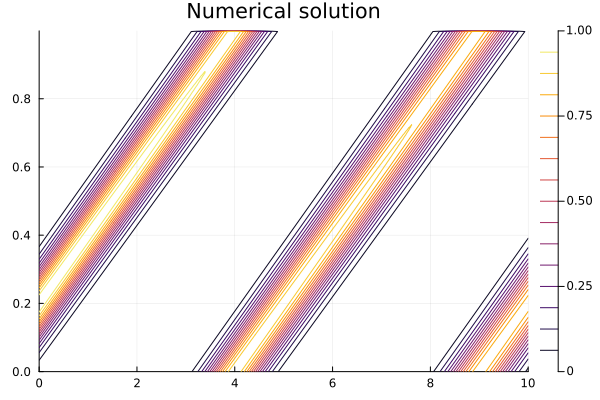

In [64]:
posind = 1:(mesh.nnodes-1) 
U  = sol[posind,:]
p1 = contour(sol.t,mesh.nodes[1:end-1],U)
title!("Numerical solution")

## Section 5: Spectral Analysis for Time Traces 

In [ ]:
unump1 = U[div(nelements,4),:]
unump2 = U[div(nelements,2),:]
unump3 = U[div(3*nelements,4),:]

p1 = plot(sol.t,unump1)
p2 = plot(sol.t,unump2)
p3 = plot(sol.t,unump3)
plot(p1,p2,p3,layout=(3,1)) 

In [ ]:
# perform FFT of sampled position data 
unumfp1 = fft(unump1)
unumfp2 = fft(unump2)
unumfp3 = fft(unump3)

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nt
fvec = Vector(0:fstep:fmax)

#..plot absolute value of FFT samples  
p1 = plot(fvec, 2.0/Nt * abs.(unumfp3[1:length(fvec)]),label="norm")
p2 = plot(fvec, angle.(unumfp3[1:length(fvec)]),label="phase")
plot(p1, p2)

## Section 6: Extend to Vector Valued Case  

Here we study a set of two coupled scalar advection equations for water height $\xi(x,t)$ and water $x$-velocity $u(x,t)$. 

<b>Linear Vector-Valued Problem to Solve</b> Let $x \in \Omega=(0,1)$ denote the spatial domain. Let $t \in [0,T]$ denote the time interval. Let $c>0$ denote the velocity of wave propagation (the direction of the wave propagation will be taken care of further). (Let $\gamma$ denote the friction coefficient.) Let $f(x,t)$ denote the (periodic or otherwise) forcing. The partial differential equations for the water height $\xi(x,t)$ and water $x$-velocity $u(x,t)$ we intend to solve can be written as    

$$
\frac{\partial \xi}{\partial t} = -H \, \text{div}(u) = -  H \, \frac{\partial u}{\partial x}  
$$

$$
\frac{\partial u}{\partial t} = -g \, [ \text{grad}(\xi) ]_x + f(x,t) = - g \, \frac{\partial \xi}{\partial x} + f(x,t)
$$

(the minus signs in the right-hand side code the direction of the wave propagation) supplied with periodic boundary conditions for both $\xi(x,t)$ and $u(x,t)$

$$
\xi(0,t) = \xi(1,t) \text{ and } u(0,t) = u(1,t) \, ,  
$$

and initial conditions for both fields. 

<b>Spatial Discretization</b>
As before, we assume an uniform mesh with $N$ elements, $N+1$ nodes ($N-1$ internal nodes plus the left-most and right-most boundary node) and mesh spacing $h = 1/N$. Due to the period boundary conditions imposed, the discretization on a mesh with $N+1$ nodes will result in linear algebra of size $N$. We employ a staggered (or [Arkawa C-grid](https://en.wikipedia.org/wiki/Arakawa_grids)) grid representation for water height  $\xi(x,t)$ and velocity $u(x,t)$. This means here that we represent $\xi(x,t)$ and $u(x,t)$ in the cell centers and cell nodes (faces), respectively. We denote the cell center of the cell extending from $x_i$ to $x_{i+1}$ by $x_{i+1/2}$. We will denote the $N$-vector of grid centers by ${\mathbf x}_m$.

After spatial discretization, $\xi(x,t)$ is approximated by a grid vector ${\mathbf \xi} \in {\mathbb R}^{N}$ (midpoints). Similarly, $u(x,t)$ is approximated by a grid vector ${\mathbf u} \in {\mathbb R}^{N+1}$ (nodes). Due to the periodic boundary conditions imposed, only first $N$ velocity components are solved for. The last velocity component $u_{N+1}$ is recovered via $u_{N+1} = u_1$. 

The staggered grid representation can be extended to two spatial dimensions as shown on e.g. [Arkawa C-grid](https://en.wikipedia.org/wiki/Arakawa_grids). Unlike figures shown on this wiki page, we draw the cell with the unknown $q = \xi$ in the cell center.    

<b>Finite Difference Approximation of the x-Derivative of $u$ in cell-centers</b> 
The $x$-derivative of the $x$-velocity $u$ can be computed in all of the $N$ cell-centers using 
$$
\frac{\partial u}{\partial x}(x=x_{i+1/2}) 
   \thickapprox \frac{u(x=x_{i+1}) - u(x=x_{i})}{h} \text{ for } 1 \leq i \leq N 
$$

In this expression, the required values of $u(x=x_{N+1})$ in the last node for $i=N$ can be eliminated using the periodic boundary condition by $u(x=x_{N+1}) = u(x=x_{1})$. We can then introduce a $N$-by-$N+1$ sparse (almost upper bi-diagonal) matrix $B$ and write that 

$$
\frac{\partial {\mathbf u}}{\partial x}({\mathbf x}_m) = -B^T \, {\mathbf u}[1:N] \in {\mathbb R}^{N} 
$$  

We introduce the transpose such that $-B$ and $B^T$ correspond to the gradient and the divergence, respecticvely. For future reference, we here give the matrix $B$ for a mesh with $N=5$ cells. Prior to eliminating $u_6$, we have that 

$$
-\widehat{B}^T = \frac{1}{h} \begin{pmatrix}
-1 & 1 & 0 & 0 & 0 & 0  \\
0  & -1 & 1 & 0 & 0 & 0 \\
0 & 0 & -1 & 1 & 0 & 0  \\
0 & 0 & 0 & -1 & 1 & 0  \\
0 & 0 & 0 & 0 & -1 & 1
\end{pmatrix}_{5 \times 6}
$$

After eliminating $u_6 = u_1$, we obtain 

$$
-B^T = \frac{1}{h} \begin{pmatrix}
-1 & 1 & 0 & 0 & 0  \\
0  & -1 & 1 & 0 & 0 \\
0 & 0 & -1 & 1 & 0  \\
0 & 0 & 0 & -1 & 1  \\
1 & 0 & 0 & 0 & -1  \\
\end{pmatrix}_{5 \times 5}
\text{ and thus }
B = \frac{1}{h} \begin{pmatrix}
1 & 0 & 0 & 0 & -1  \\
-1  & 1 & 0 & 0 & 0 \\
0 & -1 & 1 & 0 & 0  \\
0 & 0 & -1 & 1 & 0  \\
0 & 0 & 0 & -1 & 1  \\
\end{pmatrix}_{5 \times 5}
$$ 

(observe the minus sign introduced). 

<b>Finite Difference Approximation of the x-Derivative of $\xi$ in cell-nodes</b>
The $x$-component of the gradient of ${\mathbf \xi}$ can be computed in the first $N$ grid nodes. In the last ($(N+1)$-st node), this derivative is not required. We use a first order central finite difference scheme with mesh-width $h$. We more precisely have that  
$$
\frac{\partial \xi}{\partial x}(x=x_{i}) 
   \thickapprox \frac{\xi(x=x_{i+1/2}) - \xi(x=x_{i-1/2})}{h} \text{ for } 1 \leq i \leq N 
$$
where for $i=1$, we use periodicity to write that $\xi(x=x_{1-1/2}) = \xi(x=x_{N+1-1/2})$. We can then write that 

$$
\frac{\partial {\mathbf \xi}}{\partial x}({\mathbf x}[1:N]) = B \, {\mathbf \xi} \in {\mathbb R}^{N} 
$$

(again, mind the minus sign introduced).

<b>Semi-Discrete Equations</b>
The system of ODEs that result from spatial discretization can then we written as 

$$
\frac{d\mathbf{\xi}}{dt} = H \, B^T \, \mathbf{u} \text{ ($N$ nodal equations)}
$$

$$
\frac{d \mathbf{u}}{dt} = - g \, B \, \mathbf{\xi} + {\bf F}_{p} \text{ ($N$ cell-center equations)} 
$$ 

In [66]:
nelements = 5 
mesh = genMesh(nelements)
myfct(x) = 0 
B = genAdvMatL(mesh); f = genVector(mesh, myfct) 
B,f = genBoundariesL!(mesh,B,f);
display(B)

5×5 SparseMatrixCSC{Float64, Int64} with 10 stored entries:
  5.0    ⋅     ⋅     ⋅   -5.0
 -5.0   5.0    ⋅     ⋅     ⋅ 
   ⋅   -5.0   5.0    ⋅     ⋅ 
   ⋅     ⋅   -5.0   5.0    ⋅ 
   ⋅     ⋅     ⋅   -5.0   5.0

In [114]:
nelements = 99
mesh = genMesh(nelements)
myfct(x) = 0 
B = genAdvMatL(mesh); f = genVector(mesh, myfct) 
B,f = genBoundariesL!(mesh,B,f);
display(B)

99×99 SparseMatrixCSC{Float64, Int64} with 198 stored entries:
⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈
⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄

In [117]:
function advection_system!(du,u,p,t)
    p         = mesh 
    nelements = mesh.nelements
    nnodes    = mesh.nnodes  
    xi        = @view u[1:nelements]
    u         = @view u[nelements+1:end]
    du[1:nelements]  .= Transpose(B)*u 
    du[nelements+1:end] .= -B*xi .+ 0.01*sin(2*pi*t) 
end
 
xi0 = [0. for xi in mesh.midpoints]
# u10 = [0. for xi in mesh.nodes[1:end-1]]
u10 = [genAnalyticalSolution2(xi,0,c) for xi in mesh.nodes[1:end-1]]
u0  = [xi0; u10]

tspan = (0.0,3.)

p = mesh 

prob = ODEProblem(advection_system!,u0,tspan,p)
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8, save_everystep = true);

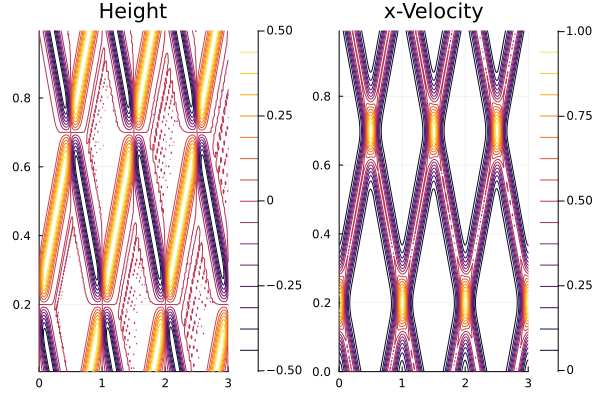

In [119]:
xiind = 1:mesh.nelements; uind = mesh.nelements+1:2*mesh.nelements; 
Nt = length(sol.t)
U1  = sol[xiind,:]
p1 = contour(sol.t,mesh.midpoints,U1)
title!("Height")
U2  = sol[uind,:]
p2 = contour(sol.t,mesh.nodes[1:end-1],U2)
title!("x-Velocity")
plot(p1, p2, layout= (1,2))

In [ ]:
velind = 1:nnodes; posind = nnodes+1:2*nnodes; 
Nt = length(sol.t)
V  = sol[velind,:]
p1 = contour(sol.t,x,V)
title!("Numerical velocity")
U  = sol[posind,:]
p2 = contour(sol.t,x,U)
title!("Numerical position")
# plot(p1, p2, layout= (1,2))
p3 = plot(sol[velind,div(Nt,4)],label="1/4 vel")
p4 = plot(sol[posind,div(Nt,4)],label="1/4 pos")
p5 = plot(sol[velind,div(Nt,2)],label="1/2 vel")
p6 = plot(sol[posind,div(Nt,2)],label="1/2 pos")
p7 = plot(sol[velind,3*div(Nt,4)],label="3/4 vel")
p8 = plot(sol[posind,3*div(Nt,4)],label="3/4 pos")
plot(p1, p2, p3, p4, p5, p6, p7, p8, layout = (4,2)) 

## References 